<a href="https://colab.research.google.com/github/C-Designer/Codestates_Section_Project/blob/main/Section1_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns   #색상 지정
import pandas as pd
import numpy as np
import scipy.stats
import math

%matplotlib inline
mpl.rc('axes', unicode_minus=False)
plt.rc('font', family='NanumBarunGothic') 
%config InlineBackend.figure_format='retina'

## 데이터 확인

In [43]:
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv')

df.info() # 16598행 10열

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


In [44]:
df.describe() # 숫자형 데이터가 Year밖에없다

,Unnamed: 0,Year
count,16598.000000,16327.000000
mean,8299.500000,1994.242543
std,4791.574219,155.077168
min,1.000000,0.000000
25%,4150.250000,2003.000000
50%,8299.500000,2007.000000
75%,12448.750000,2010.000000
max,16598.000000,2020.000000


In [45]:
df.isnull().sum()

Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

## 데이터 전처리
- 결측값 처리
- 금액단위 통합
- 날짜값 이상치 처리

#### 결측값 처리

In [46]:
df = df.iloc[:, 1:] # Unnamed 제거
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


Text(0.5, 1.0, 'Total Missing Value (%)')

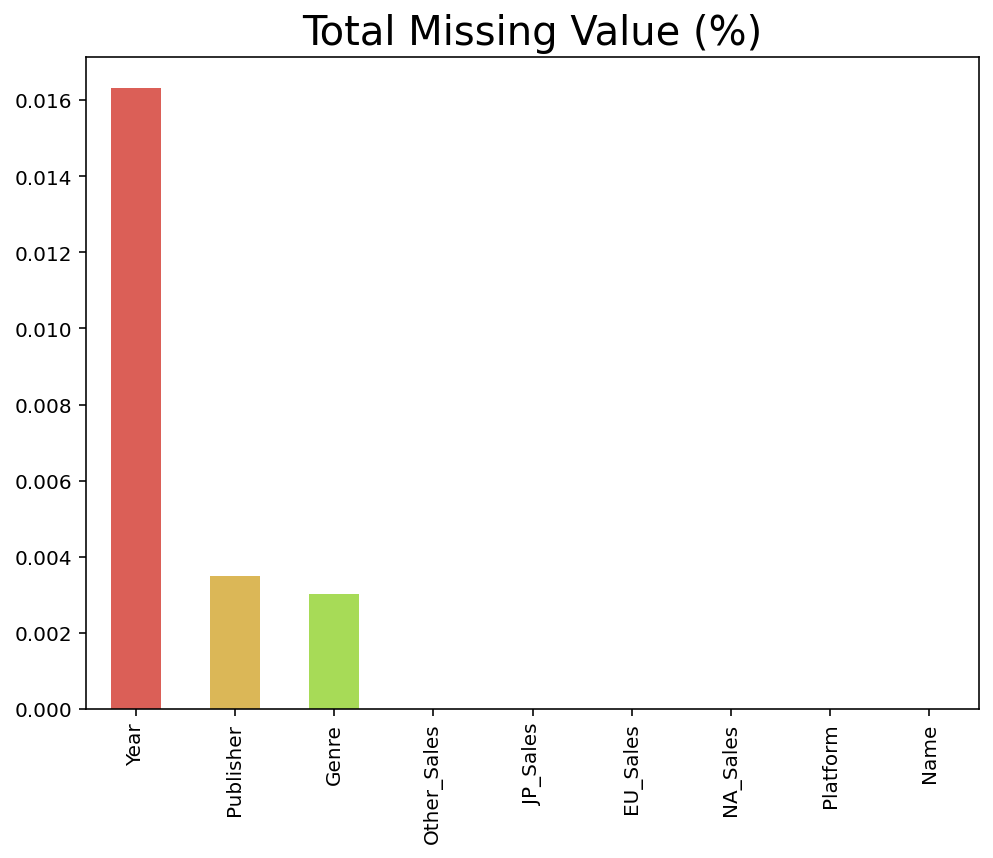

In [47]:
colors = sns.color_palette('hls', 9) #색상 지정
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10, color = colors)

plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

Text(0.5, 1.0, 'Correlation with Missing Values')

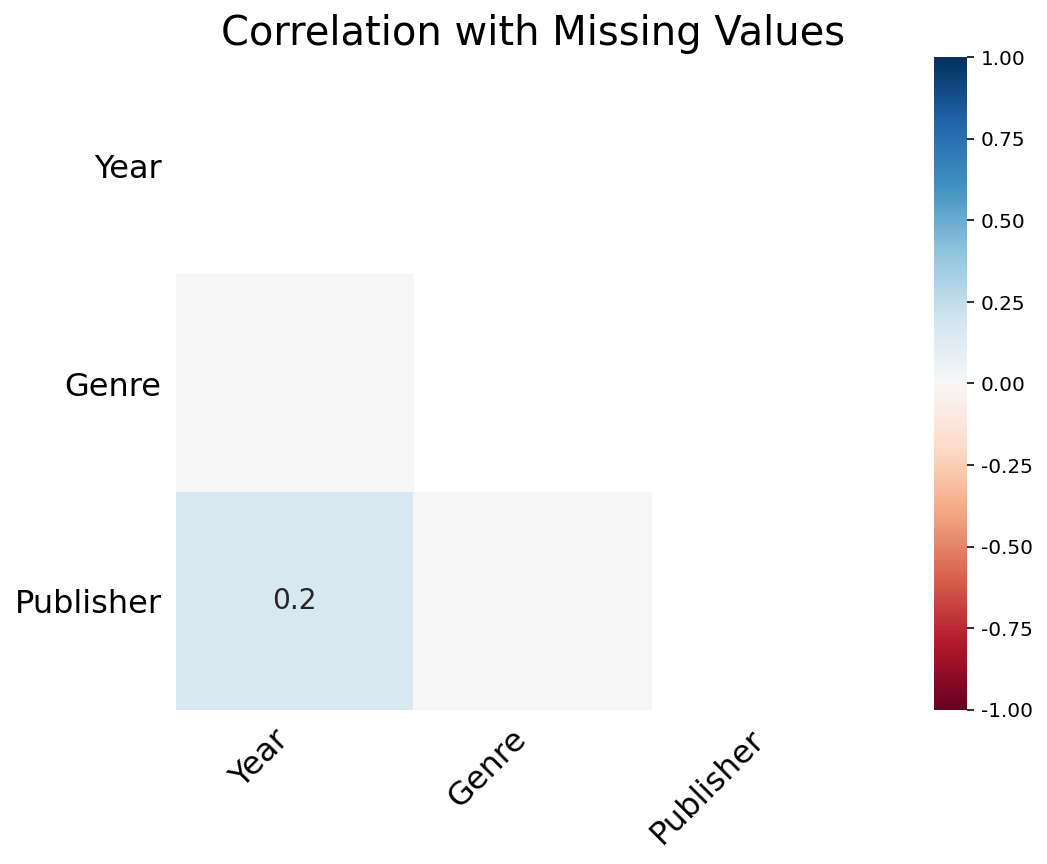

In [48]:
import missingno as msno

missingdata_df = df.columns[df.isnull().any()].tolist()
msno.heatmap(df[missingdata_df], figsize=(8,6))
plt.title("Correlation with Missing Values", fontsize = 20)

In [49]:
df[df['Year'].isnull()].head()
df[df['Publisher'].isnull()].head()
df[df['Genre'].isnull()].head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
50,Ape Escape: On the Loose,PSP,2005.0,NaN,Sony Computer Entertainment,0.52,0.01,0.12,0.05
408,NBA Ballers,XB,2004.0,NaN,Midway Games,0.37,0.11,0,0.02
1328,NFL Street,XB,2004.0,NaN,Electronic Arts,0.49,0.15,0,0.02
1582,SingStar Singalong With Disney,PS2,2008.0,NaN,Sony Computer Entertainment,0,0.04,0,0.57
1971,Pokemon X/Pokemon Y,3DS,2013.0,NaN,Nintendo,5170K,4.05,4.34,0.79


관측치인 결측값중 동일한 기준이 없어 합리적 접근이 불가하다.<br>
날짜값 이상치 처리후 장르와 퍼블리셔 결측값 처리

#### 금액 단위 통합 - M으로 통합, 1K = 0.001M, M은 제거

In [50]:
def Processing_Amount(sales):  # 금액단위 통합 : 단위 추출안될시 반환값 없음

  l = list(sales)              # 금액단위 제거
  unit = l[len(l) -1]
  del l[len(l) -1]

  if unit == 'K':              # 단위가 있을경우 금액 재추출
    sales = float(''.join(l)) * 0.001
  elif unit == 'M':
    sales = float(''.join(l))

  return float(sales) * 1000

In [51]:
sales = (df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
         .applymap(Processing_Amount)
         .astype('int')
         )

df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] = sales

df['Sum_Sales'] = sales.T.sum()
df = df.fillna(0)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sum_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,40,0,0,0,40
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,170,0,0,10,180
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,20,0,20
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,40,0,0,0,40
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,120,90,0,40,250
...,...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006.0,Platform,Vivendi Games,150,40,0,10,200
16594,Rainbow Islands: Revolution,PSP,2005.0,Action,Rising Star Games,10,0,0,0,10
16595,NBA 2K16,PS3,2015.0,Sports,Take-Two Interactive,440,190,30,130,790
16596,Toukiden: The Age of Demons,PSV,2013.0,Action,Tecmo Koei,50,50,250,30,380


#### 날짜값 이상치 처리
연도 기준의 표준편차<br>
연도별 - 2자리수 이하 21년을 기준으로 21 이하일시 +2000 / 21 초과일시 +1900

In [52]:
def Processing_Year(year):
  if year < 100:
    if year > 21:
      year += 1900
    else:
      year += 2000
  
  return year

In [53]:
pd.DataFrame(df['Year'].sort_values().head(110)).T

,13190,7008,10156,8812,3407,13954,10965,9640,952,15051,2026,15063,12324,13923,358,15093,12355,8849,7131,13889,1903,12307,15013,10144,15001,12111,2130,15897,14941,14050,14049,10119,16275,9698,16278,430,3291,9684,14968,6949,...,12616,13766,5674,8055,1041,1879,12390,10896,15147,12417,3562,13844,1011,5309,10841,1796,3605,9577,8076,15805,15216,16394,3639,10776,5230,273,10775,2142,11125,3238,2478,9877,6288,11386,11641,6257,11658,16130,11665,6223
Year,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
pd.DataFrame(df['Year'].apply(Processing_Year).sort_values().head(110)).T

,14264,12314,7317,15012,10121,13133,5938,9226,5723,5320,14984,1706,1401,8724,10126,9109,16472,6122,2052,1111,14006,16210,877,8608,3023,16263,4885,1565,1514,5072,1060,14427,1655,2618,13128,5483,8323,664,15578,3585,...,4444,3552,2661,2519,6521,15215,6567,11259,16317,13358,3833,4702,210,13548,3910,4933,10306,9420,6252,10125,13361,10658,10081,16363,12191,10570,10657,6892,12322,4310,6027,10825,6104,6499,15283,12921,5169,466,10488,4100
Year,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1980.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,1981.0,...,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1982.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1983.0,1984.0,1984.0


In [55]:
df['Year'] = df['Year'].apply(Processing_Year)

In [56]:
df = df.sort_values('Year').reset_index()
del df['index']

In [57]:
df = df.dropna()
df.isna().sum()

Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
Sum_Sales      0
dtype: int64

## 요구조건 조사
1. 지역에 따라서 선호하는 게임 장르가 다를까
2. 연도별 게임의 트렌드가 있을까
3. 매출이 높은 게임에 대한 분석 및 시각화 프로세스

#### 지역에 따라서 선호하는 게임 장르
다른 기준선이 없어 선호의 기준은 지역별 매출로 결정

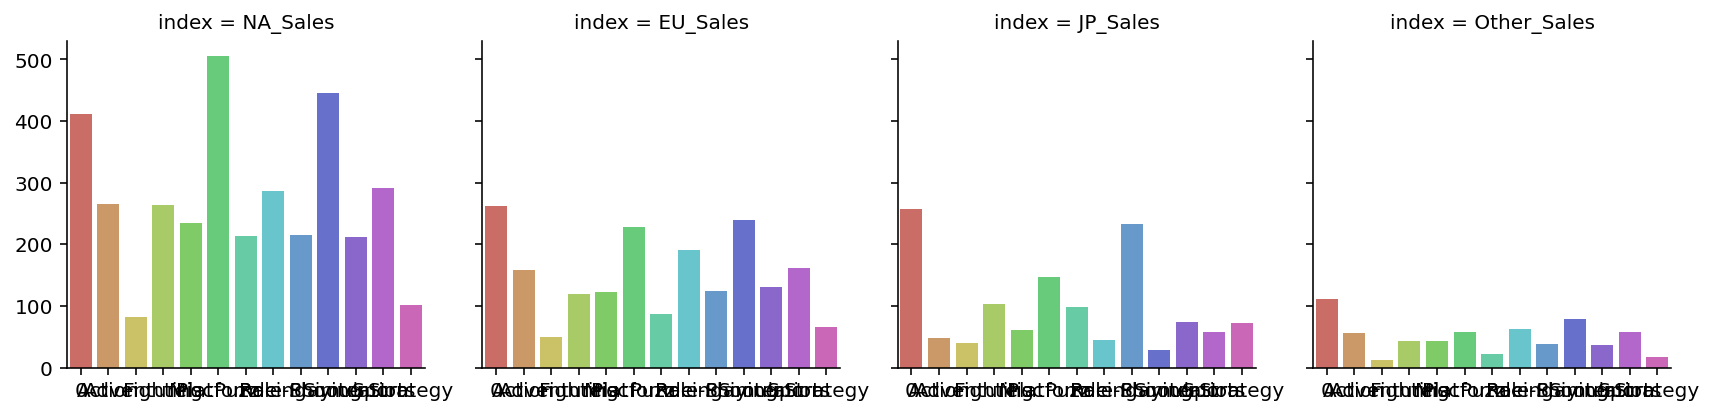

In [58]:
Genre_Sales = df[['Genre', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
Genre_Sales = Genre_Sales.groupby('Genre').mean()

location = Genre_Sales.T.reset_index()
colors = sns.color_palette('hls', len(location.T))

g = sns.FacetGrid(data = location, col = 'index') # col이 아니라 row 로도 실행해보세요.

g.map_dataframe(
    sns.barplot,
    palette = colors,
    data = location
)

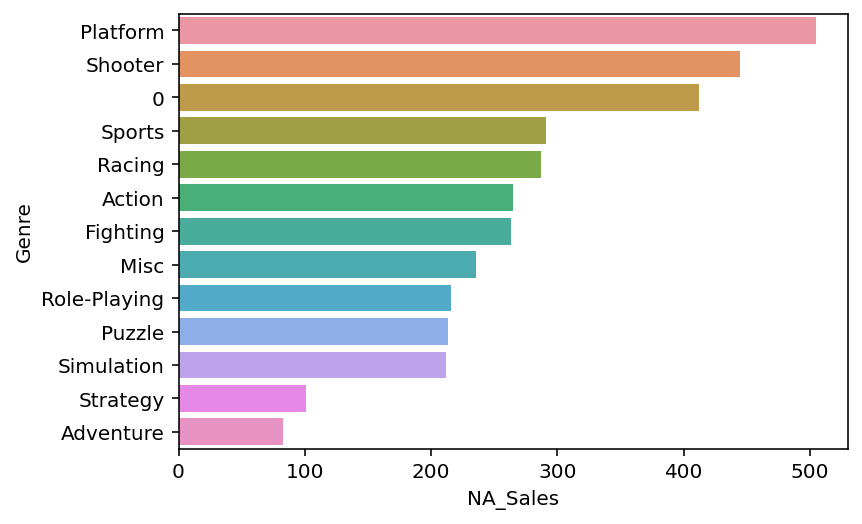

In [59]:
# 북미 매출액
NA_Genre = Genre_Sales['NA_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'NA_Sales', data= NA_Genre)

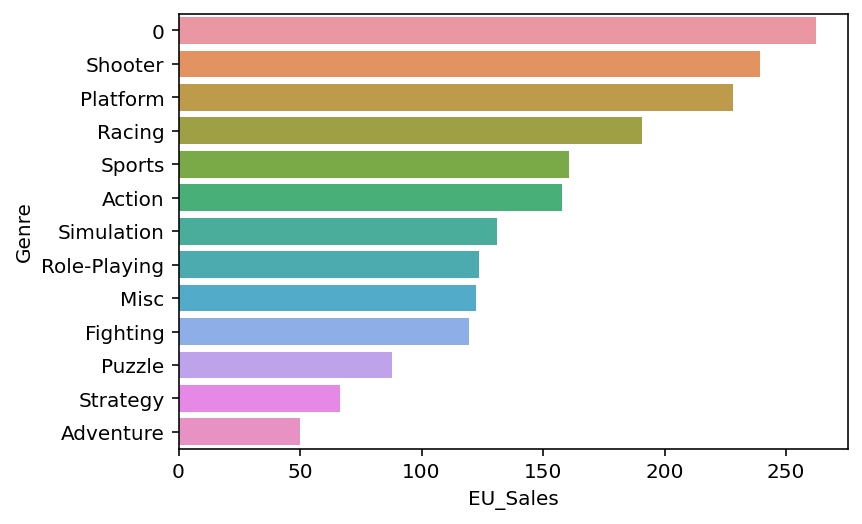

In [60]:
# 유럽 매출액
EU_Genre = Genre_Sales['EU_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'EU_Sales', data= EU_Genre)

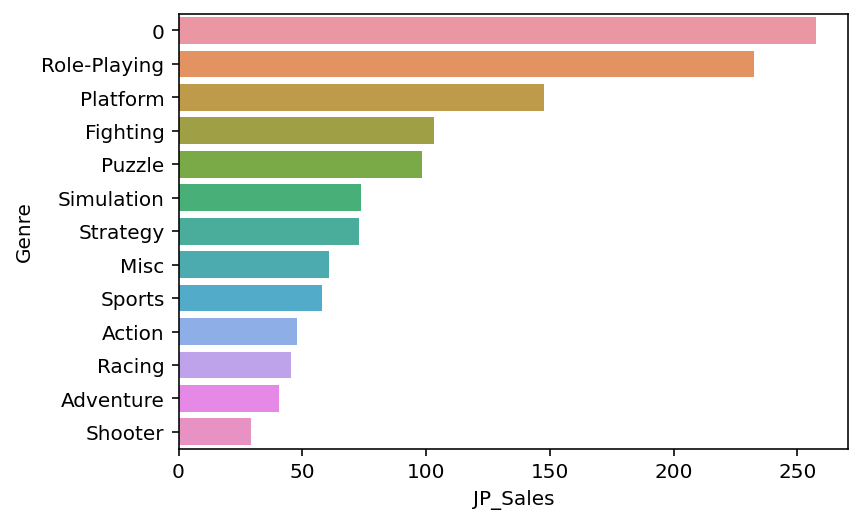

In [61]:
# 일본 매출액
JP_Genre = Genre_Sales['JP_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'JP_Sales', data= JP_Genre)

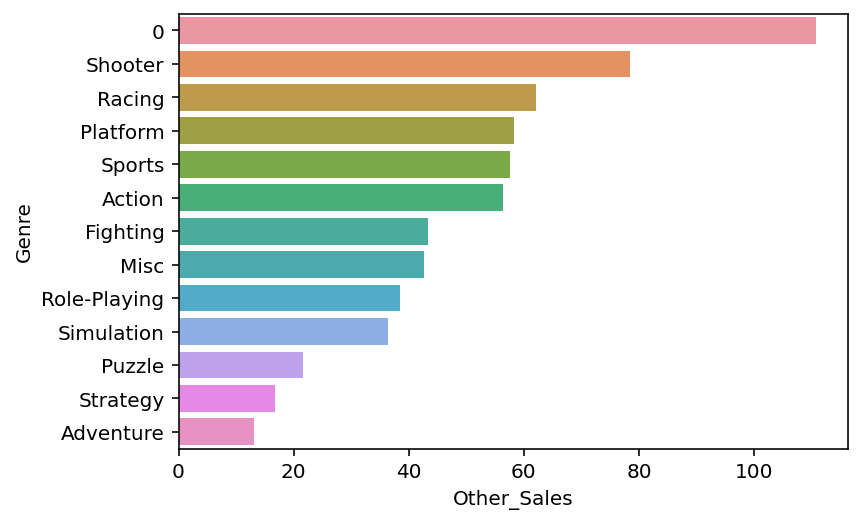

In [62]:
# 기타지역 매출액
Other_Genre = Genre_Sales['Other_Sales'].sort_values(ascending= False).reset_index()

sns.barplot(y= 'Genre', x= 'Other_Sales', data= Other_Genre)

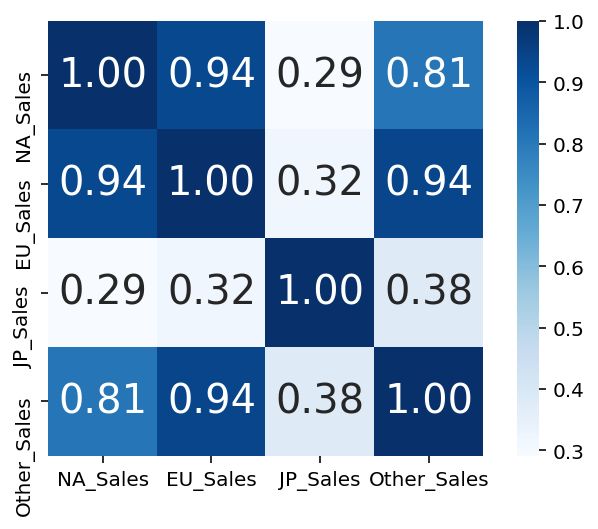

In [63]:
corr = Genre_Sales.corr(method= 'pearson')

sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 20}, fmt = '.2f', square = True, cmap = 'Blues')

In [64]:
# 최다 출시 장르 및 합산매출 최고매출 장르는 예상한 결과대로 양의 상관관계를 가지는것으로 보인다

x = sum.values
y = trend.iloc[:, 2]

scipy.stats.spearmanr(x, y).correlation

0.8578376747356404

  통계적 수치에 따른 장르별 매출 순위
  - 북미 : Platform, Shooter, Racing ...
  - 유럽 : Shooter, Platform, Racing ...
  - 일본 : Role-Playing, Platform, Fighting ...
  - 기타 : Shooter, Racing, Platform ...

  신기하게도 피어슨 상관계수를 사용하여 상관분석을 해본결과<br>
  일본빼곤 정도의 차이이지 다들 비슷한 결과가 나왔다

#### 연도별 게임의 트렌드
연간 장르별 최다 출시 장르<br>
연간 장르별 매출 합산후 최고매출 장르<br>
연간 장르별 매출평균 중 최고매출 장르

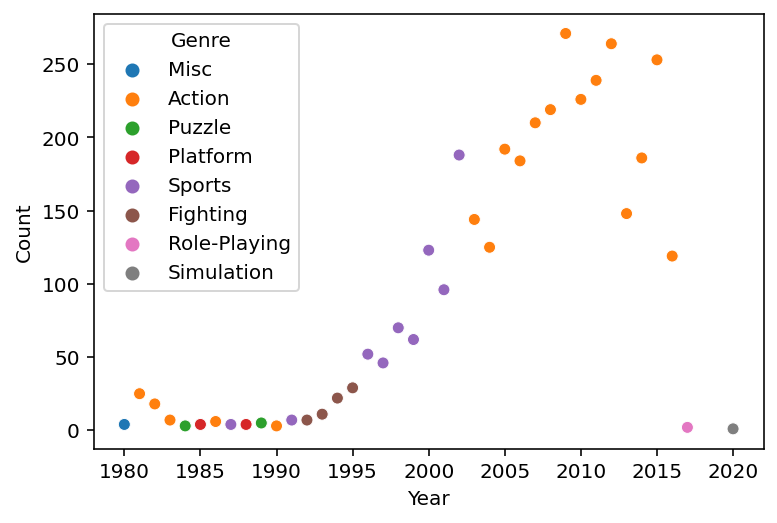

In [65]:
# 연간 게임 최다 출시갯수 장르
trend = df.groupby(['Year', 'Genre']).count().iloc[:, 1]
trend = trend.loc[trend.groupby('Year').idxmax()].to_frame().reset_index()
trend.columns = ['Year', 'Genre', 'Count']

sns.scatterplot(x= 'Year', y= 'Count', hue= 'Genre', data= trend)

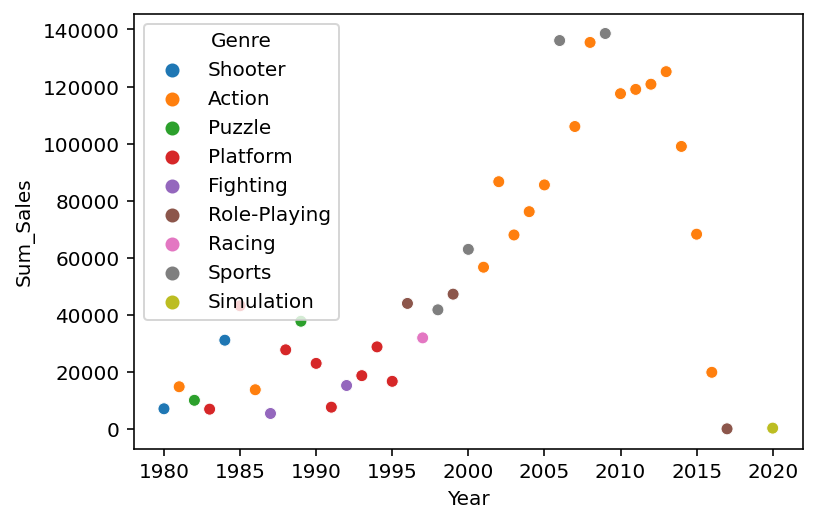

In [66]:
# 연간 장르별 매출 합산후 최고매출 장르
sum = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).sum() # 연도별 장르끼리 합치기
sum = sum.loc[sum.groupby('Year')['Sum_Sales'].idxmax()] # 연도별 매출 가장큰 장르 추출

sns.scatterplot(x= 'Year', y= 'Sum_Sales', hue= 'Genre', data= sum)

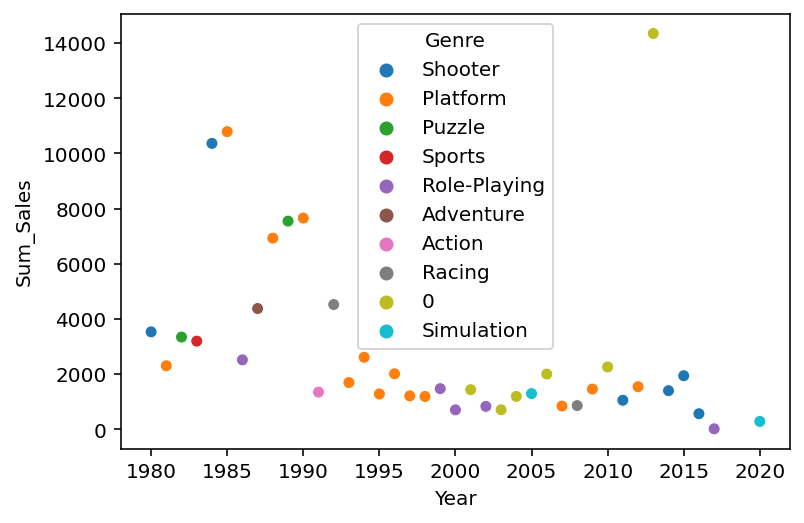

In [67]:
# 연간 장르별 매출평균 중 최고매출 장르
mean = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).mean() # 연도별 장르끼리 합치기
mean = mean.loc[mean.groupby('Year')['Sum_Sales'].idxmax()] # 연도별 매출 가장큰 장르 추출

sns.scatterplot(x= 'Year', y= 'Sum_Sales', hue= 'Genre', data= mean)

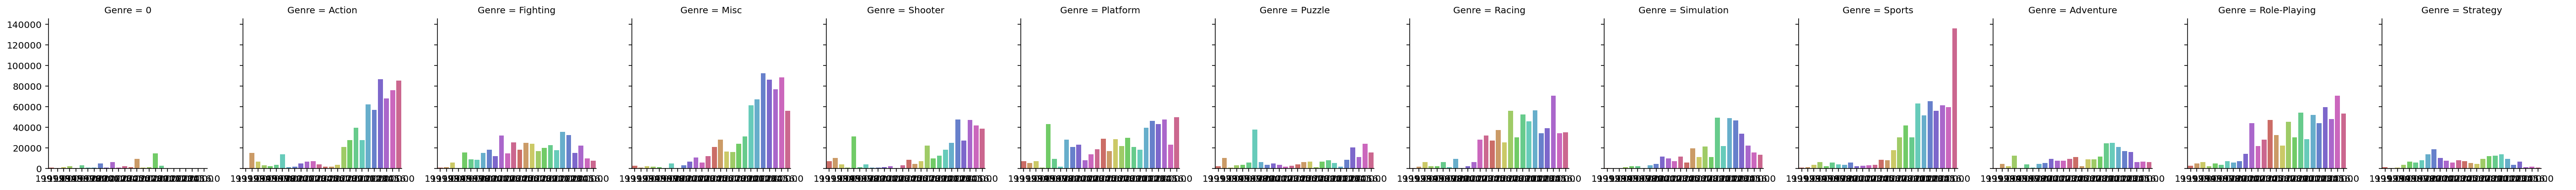

In [68]:
# 장르별 연간 매출

Genre = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).sum().reset_index()

g = sns.FacetGrid(data = Genre, col = 'Genre')
colors = sns.color_palette('hls', len(df['Genre'].unique()))

g.map_dataframe(
    sns.barplot,
    x = 'Year',
    y = 'Sum_Sales',
    data = Genre,
    palette = colors
)
g.add_legend();

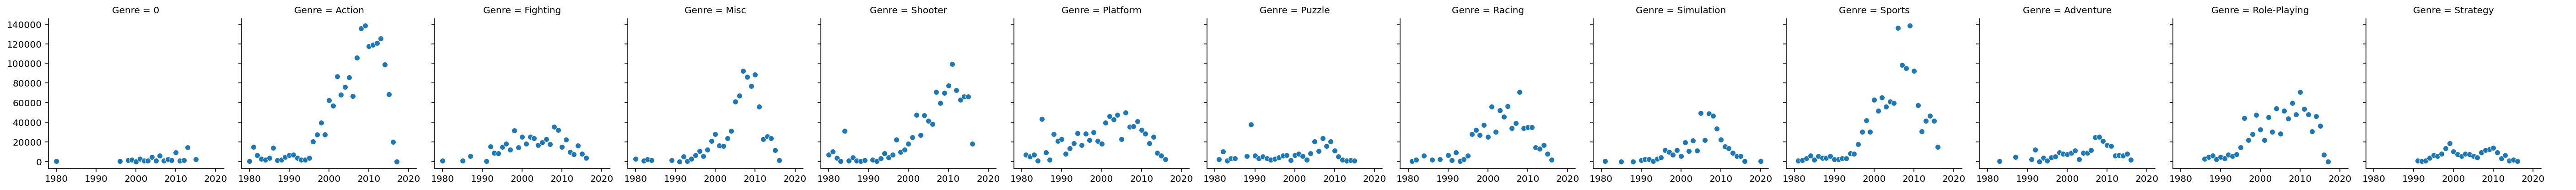

In [69]:
Genre = df[['Year', 'Genre', 'Sum_Sales']].groupby(['Year', 'Genre']).sum().reset_index()

g = sns.FacetGrid(data = Genre, col = 'Genre')
colors = sns.color_palette('hls', len(df['Genre'].unique()))

g.map_dataframe(
    sns.scatterplot,
    x = 'Year',
    y = 'Sum_Sales',
    data = Genre,
    palette = colors
)
g.add_legend();

  트렌드의 기준을 무엇으로 둬야할지 애매해서 나누어 분석하였다<br>
  - 연간 장르별 최다 출시 장르
  - 연간 장르별 매출 합산후 최고매출 장르
  - 연간 장르별 매출평균 중 최고매출 장르
  - 장르별 연간매출
  
  2000년을 기점으로 액션, 스포츠 장르가 주축을 이루는 것으로 보인다<br>
  콘솔게임 시장의 급격한 축소로 인한 매출감소를 제외한다면
  장르별 연간 매출을 조사해본 결과 스포츠, 액션, role-playing은 상향곡선을 그리고 있다.

#### 매출이 높은 게임에 대한 분석 및 시각화 프로세스

In [70]:
# 매출 상위 1%
top_Game = df.sort_values('Sum_Sales', ascending= False).iloc[:int(len(df) * 0.01)]
top_Game = top_Game[['Platform', 'Genre', 'Publisher', 'Sum_Sales']]
top_Game

,Platform,Genre,Publisher,Sum_Sales
6486,Wii,Sports,Nintendo,82740
125,NES,Platform,Nintendo,40240
9084,Wii,Racing,Nintendo,35830
11170,Wii,Sports,Nintendo,33000
889,GB,Role-Playing,Nintendo,31380
...,...,...,...,...
13292,PS3,Action,Warner Bros. Interactive Entertainment,5520
9504,PSP,Role-Playing,Capcom,5510
2769,GBA,Platform,Nintendo,5490
2848,GBA,Racing,Nintendo,5480


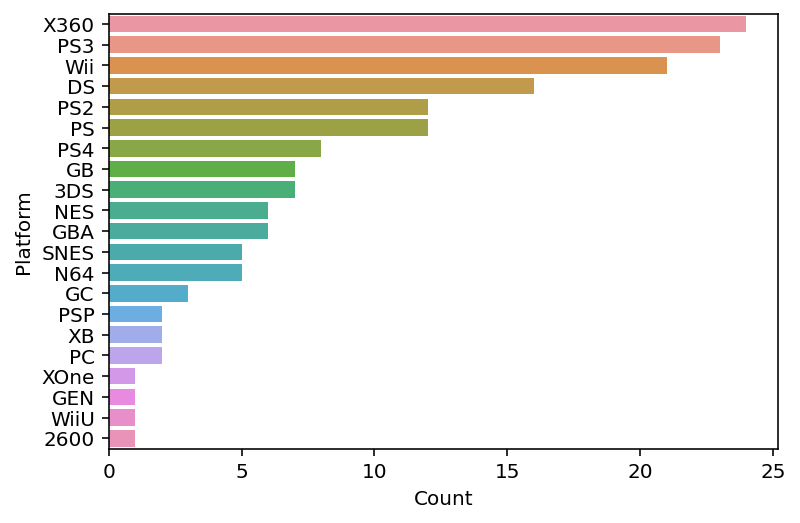

In [71]:
# 상위 1% 플랫폼비율
top_Platform = (top_Game.groupby('Platform').count()  # 카운팅
  .iloc[:, 1]   # 관련없는 열 제거
 .sort_values(ascending= False)  # 내림차순
 .reset_index()
 )

top_Platform.columns = ['Platform', 'Count']

sns.barplot(x= 'Count', y= 'Platform', data= top_Platform)

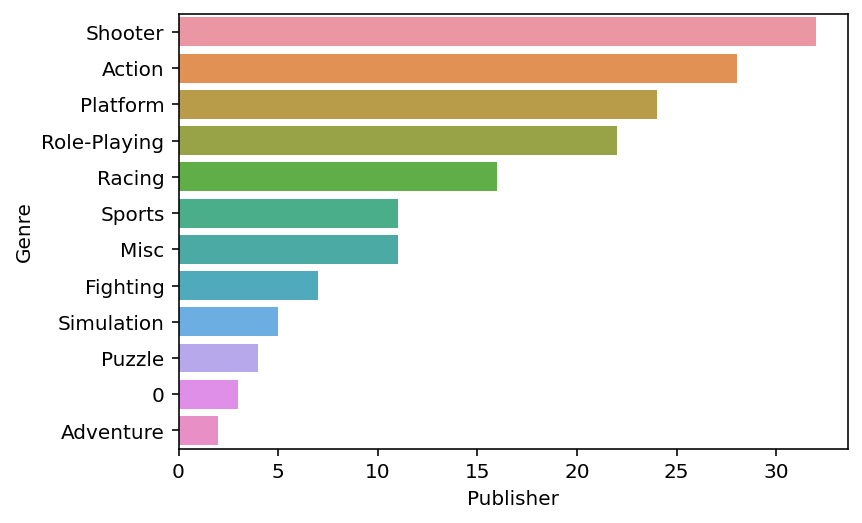

In [72]:
# 상위 1% 장르비율
top_Genre = top_Game.groupby('Genre').count().iloc[:, 1].sort_values(ascending= False).reset_index()

sns.barplot(x= 'Publisher', y= 'Genre', data= top_Genre)

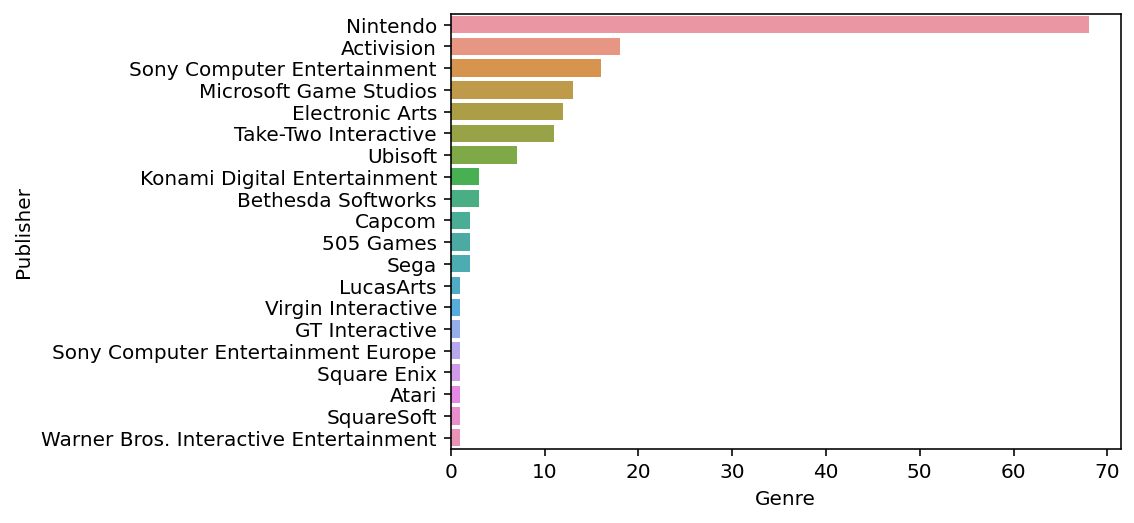

In [73]:
# 상위 1% 퍼블리셔비율
top_Publisher = top_Game.groupby('Publisher').count().iloc[:, 1].sort_values(ascending= False).reset_index()

sns.barplot(x= 'Genre', y= 'Publisher', data= top_Publisher)

  매출상위 1%를 기준으로 나열한 순위이다
  - 플랫폼 비율 : x360, PS3, Wii, DS ..
  - 장르 비율 : Shooter, Action, Platform, Role_Playing ..
  - 퍼블리셔 비율 : Nintendo, Activision, Sony .. 


Genre    446.877928
dtype: float64

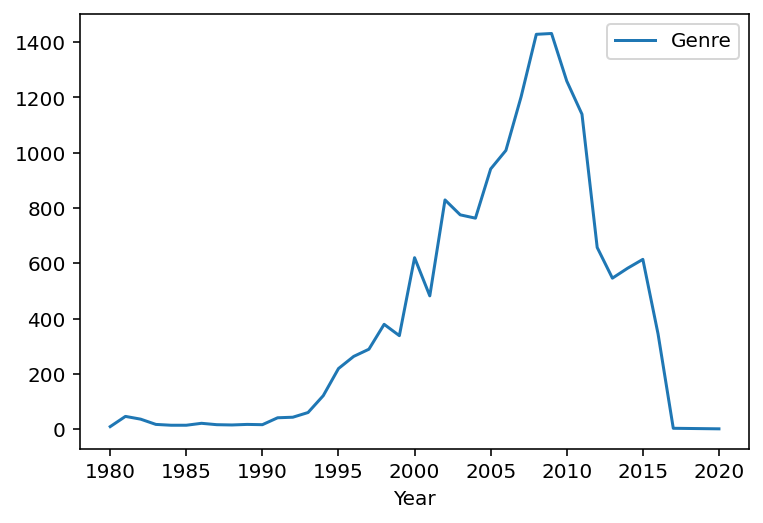

In [74]:
# 연도별 데이터수의 표준편차
from scipy.stats import chisquare

count_by_years = df[['Year', 'Genre']].groupby('Year').count()
count_by_years.plot()

np.std(count_by_years)

In [75]:
top_Platform = top_Platform.set_index('Platform')

PS = ['PS3', 'PS', 'PS2', 'PS4', ]

In [77]:
df.describe() # 숫자형 데이터가 Year밖에없다

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Sum_Sales
count,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,2006.301844,264.666767,146.651765,77.781660,48.062959,537.163152
std,5.837932,816.681453,505.349625,309.290648,188.587776,1555.147145
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,80.000000,20.000000,0.000000,10.000000,170.000000
75%,2010.000000,240.000000,110.000000,40.000000,40.000000,470.000000
max,2020.000000,41490.000000,29020.000000,10220.000000,10570.000000,82740.000000
